In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import sys
sys.path.insert(0, 'code')

from robot_data import Load_Lidar_Scans as load_scans
from robot_data import Lidar_Scan
from robot_data import robot_trajectory
from datafilters import filters
import coordinate_transforms as cord_trans
import visualizer
import ICP

# All the variables that have been created to retrieve the data:

In [2]:
scans_OBJ = load_scans()
scans_OBJ.load_ranges('data\\LidarScans_ranges.txt')
scans_OBJ.load_angles('data\\LidarScans_angles.txt')

trajectory_OBJ = robot_trajectory()
trajectory_OBJ.load_trajectory('data\\Trajectory.txt')

print('Trajectory: ',trajectory_OBJ.trajectory.shape)
print('traj_len: ',trajectory_OBJ.trajectory_length)
print('traj_dim: ',trajectory_OBJ.trajectory_dimension,'\n')

print('LidarScans: ',scans_OBJ.LidarScan_ranges.shape)
print('num_of_lidarscans: ',scans_OBJ.num_of_LidarScans)
print('LidarScans_angles: ',scans_OBJ.LidarScan_angles.shape)

Trajectory:  (52, 3)
traj_len:  52
traj_dim:  2 

LidarScans:  (51, 240)
num_of_lidarscans:  240
LidarScans_angles:  (240,)


# So at this point I have the odometry measurements, all lidar scans as well as the angles corresponding to those scans

In [3]:
#envir_axes = [[np.amin(Trajectory[:,0])-8,np.amax(Trajectory[:,0])+8],[np.amin(Trajectory[:,1])-8,np.amax(Trajectory[:,1])+8]]
#fig = plt.figure(1, figsize=(5.5,5.5));
#plt.xlim(envir_axes[0]);
#plt.ylim(envir_axes[1]);

# This is a note for the code. This can be added to the report

More precisely, given two point clouds, R (the reference) and S (the source), ICP tries to find the best rigid (or similarity) transform T so that T * S = R.

# The following variables are used for the pose-graph SLAM algorithm

In [4]:
neighbors_to_match_to = 3
# The number of points that read is matched to in the reference

match_threshold_distance = 1
# The maximum distance that a point in the read may be from a 
# point in the reference 

match_threshold_angle = np.pi/3
# The maximum angle between a line through a point in the 
# read may have from a line through a point in the reference

maximum_iterations = 80
# Maximum number of iterations that the ICP algorithm may be run

maximum_transform_limits = [0.8,15]
# maximum rotation and displacement limits between pose's

final_error_limit = 70
# maximum loop closure limit 

ICP_success = [0.001,0.01]
# conditions for success between successive ICP iterations

overlap_threshold = 0.75
# The amount of overlap that a read must have with the reference

robot_state = 0
# Indicates whether the robot is exploring or revisiting

keyframes = []
# Scans used to create the pose graph

local_map = []
# The sequence of keframes that the robot uses to create a map with 
# which it it comapres new scans to.

local_map_size = 3
# This is the number of keyframes that the robot uses to create the 
# local map, which it uses during exploration

no_loop_window = 10
# The number of previous and sequentail keyframes that may not be considered
# for the loop closure process

max_distance_to_loop_closing = 15
max_error_for_loop_closing = 5000

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [264]:
def outlier_rejection(distances_read_refnorm,angles_read_refnorm):
    rejection_weights_per_point = []
    rejection_weights = np.zeros([distances_read_refnorm.shape[1],distances_read_refnorm.shape[1],distances_read_refnorm.shape[0]])
    for angles_to_multi_plane,distances_to_multi_plane in zip(angles_read_refnorm,distances_read_refnorm):
        for angle_to_plane,distance_to_plane in zip(angles_to_multi_plane,distances_to_multi_plane):
            if(distance_to_point > 1 and angle_to_plane > match_threshold_angle):
                rejection_weights_per_point = np.append(rejection_weights_per_point,0)
            else:
                rejection_weights_per_point = np.append(rejection_weights_per_point,1)
        for j,weight in enumerate(rejection_weights_per_point):
            rejection_weights[j,-1,i] = weight
    return rejection_weights

In [262]:
test = np.zeros([4,4],dtype='int')
print(test)
test = np.delete(test,3,1)
print(test)
weights = np.vstack(np.array([1,0,1,0]))
print(weights)
weights = np.append(test,weights,axis=1)
print(weights)
data = np.array([[1,1],[1,1],[1,1],[1,1]])
print(data)
print(np.matmul(weights,data))

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[1]
 [0]
 [1]
 [0]]
[[0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]]
[[1 1]
 [1 1]
 [1 1]
 [1 1]]
[[1 1]
 [0 0]
 [1 1]
 [0 0]]


In [265]:
def matching(reference, read):
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(reference)
    distances, indices = nbrs.kneighbors(read)
    matched_points = np.zeros([3,2,indices.shape[0]])
    for i,ref_point in enumerate(indices):
        single_matched_point = np.zeros(2)
        for j,k in enumerate(ref_point):
            #if not (distances[i,j] > 1 and ):
            x,y = reference[k]
            single_matched_point = np.append(single_matched_point,[x,y])
            #else:
                #indices[i,j] = -1
                #single_matched_point = np.append(single_matched_point,[np.nan,np.nan])
        single_matched_point = np.reshape(single_matched_point,(-1,2))
        single_matched_point = np.delete(single_matched_point,0,0)
        for j,save_point in enumerate(single_matched_point):
            matched_points[j,:,i] = save_point 
    return matched_points,indices        

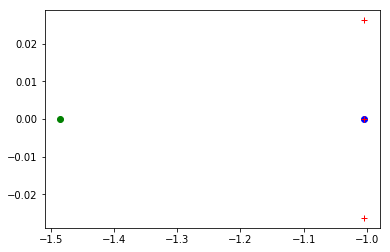

In [266]:
reference = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
read = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])

matched,correspondence_points = matching(reference, read)

plt.figure()
plt.plot(reference[0,0],reference[0,1],'bo')
plt.plot(read[0,0],read[0,1],'go')
plt.plot(matched[:,0,0],matched[:,1,0],'r+')

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [7]:
def read_reference_transform():
    return

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
http://geomalgorithms.com/a04-_planes.html

In [8]:
def distance(read_p, reference_q_normal):
    return np.dot(read_p,reference_q_normal)    

In [9]:
print(distance([0,1],[1,1]))

1


# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [10]:
alpha, beta, gama, tx, ty, tz = 0,0,0,0,0,0

#rotational_compontents = np.array([[alpha],[beta],[gama]])
#translation_compontents = np.array([[tx],[ty],[tz]])
#transformation_parameters = np.reshape([rotational_compontents,translation_components],(-1,1))

rotational_skew_symmetric = np.array([[0,-gama,beta],[gama,0,-alpha],[-beta,alpha,0]])
identity_matrix = np.eye(3)
rotation_matrix_linearization = rotational_skew_symmetric + identity_matrix

In [11]:
def point_to_plane_error_minimization(read,reference,initial_transformation_guess):
    
    def LMICP_error(x):
        f = [x[0] * np.cos(x[1]) - 4,
             x[1]*x[0] - x[1] - 5]
        df = np.array([[np.cos(x[1]), -x[0] * np.sin(x[1])],
                       [x[1], x[0] - 1]])
        return f, df
    
    sol = root(LMICP_error, [1, 1], jac=True, method='lm')
    
    return

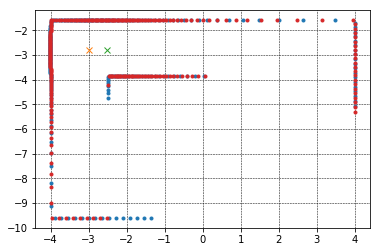

In [12]:
plt.figure()
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,1] + coords_xy[:,1],'.')
plt.plot(trajectory_OBJ.trajectory[0,0],trajectory_OBJ.trajectory[0,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
plt.plot(trajectory_OBJ.trajectory[1,0],trajectory_OBJ.trajectory[1,1],'x')
plt.plot(trajectory_OBJ.trajectory[1,0] + coords_xy[:,0],trajectory_OBJ.trajectory[1,1] + coords_xy[:,1],'.')

In [14]:
def transformation_2D(parameters,x):
    theta,tx,ty = parameters
    rotation_matrix = np.array([[np.cos(theta),np.sin(theta)],[-1*np.sin(theta),np.cos(theta)]])
    translation_matrix = np.array([[tx],[ty]])
    x = np.transpose(x)
    new_cloud = np.transpose(np.matmul(rotation_matrix,x) + translation_matrix)
    return new_cloud,parameters

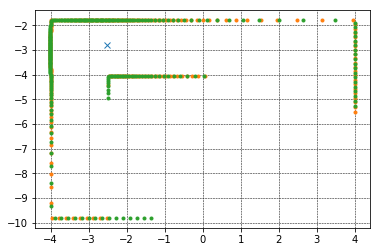

In [35]:
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[1])
translation = np.vstack(trajectory_OBJ.trajectory[1] - trajectory_OBJ.trajectory[0])

test,trans = transformation_2D([trajectory_OBJ.trajectory[0,2],translation[0,0],translation[1,0]],coords_xy)

plt.figure()
#plt.plot(x[:,0],x[:,1],'.')
plt.plot(trajectory_OBJ.trajectory[1,0],trajectory_OBJ.trajectory[1,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.plot(trajectory_OBJ.trajectory[0,0] + test[:,0],trajectory_OBJ.trajectory[0,0] + test[:,1],'.')

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,0] + coords_xy[:,1],'.')

In [24]:
print(np.vstack(trajectory_OBJ.trajectory[1] - trajectory_OBJ.trajectory[0]))

[[0.48333]
 [0.00000]
 [0.00000]]


In [ ]:
def transformation_parameters(path):
        transformation_parameters_between_pose = np.zeros(3)
        for i in range(np.linspace(1,path.shape[0] - 1,dtype='int')):
            x,y = path[i]
            transformation_parameters_between_pose = np.append(transformation_parameters_between_pose,x,y,theta)
    return

In [181]:
print()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51]


# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [13]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

In [14]:
def angle_between(vector1,vector2):
    angle = np.arccos(np.clip(np.dot(vector1, vector2), -1.0, 1.0))
    cross = np.cross(vector1, vector2)
    angle = angle*np.sign(np.dot(vector1,cross))
    return angle[0]

In [15]:
def observation_normal_angle_minimize(normal_vectors,obse_sens_vectors):
    angle = np.zeros(1)
    for i in range(normal_vectors.shape[0]):
        unit_vectors = [obse_sens_vectors[i],normal_vectors[i]]
        temp = angle_between(unit_vectors[0], unit_vectors[1])
        if(temp > np.pi):
            temp = temp - np.pi
        angle = np.append(angle,temp)
        
    return np.reshape(angle,(-1,1))

In [16]:
norm = np.array([0,-1])
ob_se = np.array([1,0])
unit_vectors = [ob_se,norm]
angle_between(unit_vectors[0], unit_vectors[1])

-1.5707963267948966

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

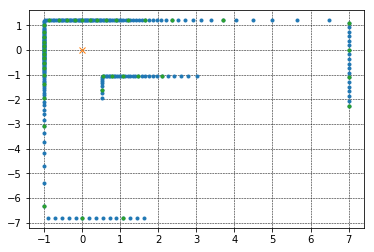

In [9]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = filters.subsample(coords_xy,6)
plt.plot(test[:,0],test[:,1],'.')

0.5083333333333333


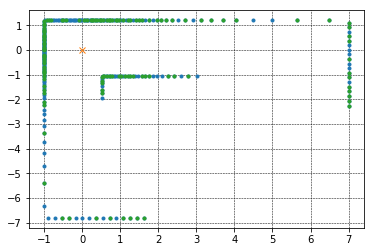

In [16]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = filters.random_sample_uniform(coords_xy,0.5)
plt.plot(test[:,0],test[:,1],'.')

print(test.shape[0]/coords_xy.shape[0])

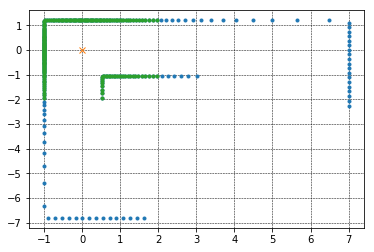

In [11]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

test = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])

test = filters.bounded_box(test,[-2,2],[-2,2])
plt.plot(test[:,0],test[:,1],'.')

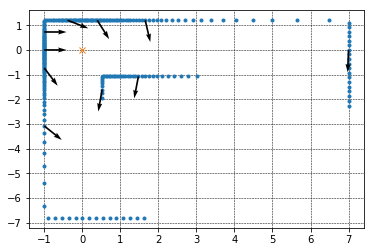

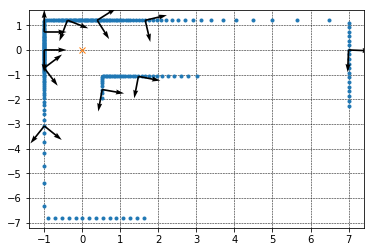

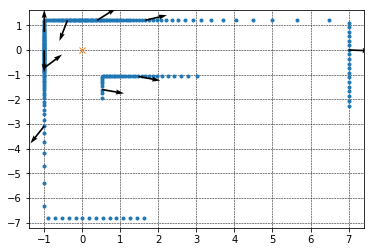

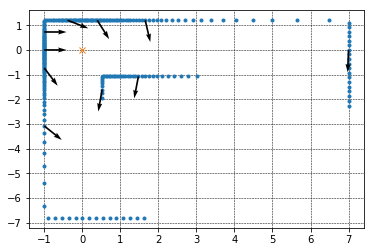

In [24]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

normal_vectors, axes = filters.surface_normals(coords_xy,10)

steps = np.linspace(0,240,10,endpoint=False,dtype='int')

for i in steps:
    visualizer.plot_custom_axes(normal_vectors[i],test[i])

    
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)    

for i in steps:
    visualizer.plot_custom_axes(axes[i,0],test[i])
    
for i in steps:
    visualizer.plot_custom_axes(axes[i,1],test[i])

    
    
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

for i in steps:
    visualizer.plot_custom_axes(axes[i,0],test[i])
    
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)    

for i in steps:
    visualizer.plot_custom_axes(axes[i,1],test[i])

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Testing the co-ordinate transforms

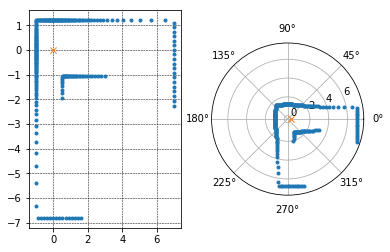

In [20]:
plt.figure()

plt.subplot(1, 2, 1)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2,projection='polar')
coords_polar = cord_trans.cartesian_to_ploar_2D(coords_xy)
plt.polar(coords_polar[:,1],coords_polar[:,0],'.')
plt.polar(0.,0.,'x')

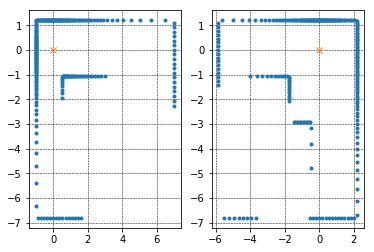

In [21]:
plt.figure()

plt.subplot(1, 2, 1)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[10])
plt.plot(coords_xy[:,0],coords_xy[:,1],'.')
plt.plot(0,0,'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

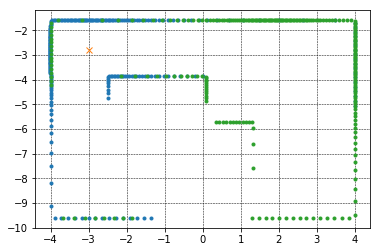

In [22]:
plt.figure()

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])
plt.plot(trajectory_OBJ.trajectory[0,0] + coords_xy[:,0],trajectory_OBJ.trajectory[0,1] + coords_xy[:,1],'.')
plt.plot(trajectory_OBJ.trajectory[0,0],trajectory_OBJ.trajectory[0,1],'x')
plt.grid(color='k', linestyle='--', linewidth=0.5)

coords_xy = cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[10])
plt.plot(trajectory_OBJ.trajectory[10,0] + coords_xy[:,0],trajectory_OBJ.trajectory[10,1] + coords_xy[:,1],'.')

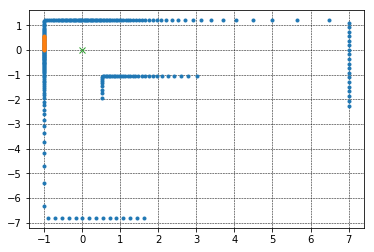

In [23]:
visualizer.plot_scan_surfaces(cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0]),cord_trans.ploar_to_cartesian_2D(scans_OBJ.LidarScan_angles,scans_OBJ.LidarScan_ranges[0])[0:21])

(2, 2)
(2, 2)


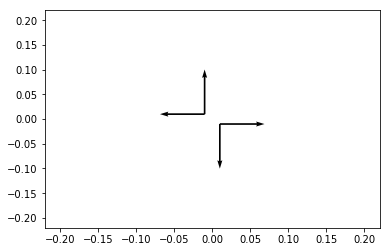

In [25]:
axes = np.array([[1.,0.],[0.,-1.]])
print(axes.shape)
visualizer.plot_custom_axes(axes,[0.01,-0.01])
axes = np.array([[-1.,0.],[0.,1.]])
print(axes.shape)
visualizer.plot_custom_axes(axes,[-0.01,0.01])

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx